# Predicting house prices with Deep Learning (keras)

A common type of machine-learning problem is regression, which consists of predicting a continuous
value instead of a discrete label: for instance, predicting the temperature tomorrow,
given meteorological data; or predicting the time that a software project will take to
complete, given its specifications.

In the next examples we will predict the house price base on different parameters.

# 1st example:

Dataset: Boston suburb (features = 13)

Source: keras preload dataset

In [1]:
# Predicting house prices
# - regression example
# Dataset: Boston suburb in the mid-1970 with 13 features

# Deep learning library

from keras.datasets import boston_housing
from keras import models
from keras import layers

# Python libraries

from io import StringIO
import requests
import json
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [2]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu',
                           input_shape = (train_data.shape[1], )))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics=['mae'])
    return model

def build_a_model(units):
    model = models.Sequential()
    model.add(layers.Dense(units, activation = 'relu',
                           input_shape = (train_data.shape[1], )))
    model.add(layers.Dense(units, activation = 'relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics=['mae'])
    return model

def kagglemodel(units, dataset):
    kmodel = models.Sequential()
    kmodel.add(layers.Dense(units, activation = 'relu',
                           input_shape = (dataset.shape[1], )))
    kmodel.add(layers.Dense(units, activation = 'relu'))
    kmodel.add(layers.Dense(1))
    kmodel.compile(optimizer = 'rmsprop', loss = 'mse', metrics=['mae'])
    return kmodel

In [3]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [4]:
# Train targets: median values of owner-occupied homes (thousands of dollars)

print("Train data shape: " + str(train_data.shape))
print("\nTest data shape: " + str(test_data.shape))
print("\nTrain targets: " + str(train_targets[0:16]))

Train data shape: (404, 13)

Test data shape: (102, 13)

Train targets: [ 15.2  42.3  50.   21.1  17.7  18.5  11.3  15.6  15.6  14.4  12.1  17.9
  23.1  19.9  15.7   8.8]


# Preparing the data

Many different features in the input data (for example, the crime rate) has a different scale. 
For instance, some values are proportions, which take values between 0 and 1; others take values between 1 and 12, others
between 0 and 100, and so on.

A widespread best practice to deal with such data is to normalization 
in other word means adjusting values measured on different scales to a notionally common scale, often prior to averaging.

In [5]:
mean = train_data.mean(axis = 0)
train_data -= mean

std = train_data.std(axis = 0)
train_data /= std

test_data -= mean
test_data /= std

# K-fold validation

When you have so few data points, the validation set would end up being very small.

As a consequence, the validation scores might change a lot depending on which data
points you chose to use for validation and which you chose for training.

For example the current example just have the next:    
    404 samples for training
    102 samples for test

In this cases the best practice in such situations is to use K-fold cross-validation.
It consists of splitting the available data into K partitions (typically K = 4 or 5),
and training each one on K – 1 partitions while evaluating on
the remaining partition. 

The validation score for the model used is then the average of
the K validation scores obtained.

In [6]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('\nProcessing fold #', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
         axis = 0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i+1) * num_val_samples:]],
         axis = 0)    
    
    model01 = build_model()
    model01.fit(partial_train_data, partial_train_targets,
              epochs = num_epochs, batch_size = 1, verbose = 0)
    
    val_mse, val_mae = model01.evaluate(val_data, val_targets)
    all_scores.append(val_mae)


Processing fold # 0
 32/101 [========>.....................] - ETA: 0s
Processing fold # 1
 32/101 [========>.....................] - ETA: 0s
Processing fold # 2
 32/101 [========>.....................] - ETA: 0s
Processing fold # 3
 32/101 [========>.....................] - ETA: 0s

In [7]:
print("Scores: " + str(all_scores))

Scores: [2.0926998039283373, 2.0865861283670557, 2.9219665385708948, 2.4265665866360804]


In [8]:
print("Mean score: " + str(np.mean(all_scores)))

Mean score: 2.38195476438


In [9]:
from keras import backend as D

D.clear_session()

In [10]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print("\nProcessing fold # ", i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
         axis = 0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i+1) * num_val_samples:]],
         axis = 0)  
    
    model02 = build_model()
    history = model02.fit(partial_train_data, partial_train_targets,
              validation_data = (val_data, val_targets),
              epochs = num_epochs, batch_size = 1, verbose = 0)
    
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)


Processing fold #  0

Processing fold #  1

Processing fold #  2

Processing fold #  3


In [11]:
 average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [13]:
def smooth_curve(points, factor = 0.9):
    
    smoothed_points = []
    
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else: 
            smoothed_points.append(point)
    
    return smoothed_points

In [14]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

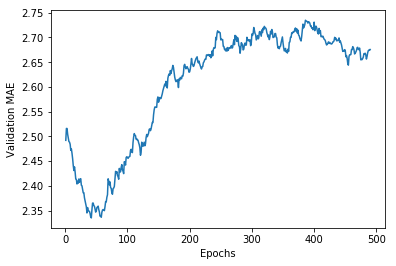

In [15]:
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [16]:
num_epochs03 = 80
batch = 16
all_mae_histories03 = []

for i in range(k):
    print("\nProcessing fold # ", i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
         axis = 0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i+1) * num_val_samples:]],
         axis = 0)  
    
    model03 = build_a_model(64)
    history = model03.fit(partial_train_data, partial_train_targets,
              validation_data = (val_data, val_targets),
              epochs = num_epochs03, batch_size = batch, verbose = 0)
    
    mae_history03 = history.history['val_mean_absolute_error']
    all_mae_histories03.append(mae_history03)


Processing fold #  0

Processing fold #  1

Processing fold #  2

Processing fold #  3


In [17]:
average_mae_history03 = [np.mean([x[i] for x in all_mae_histories03]) for i in range(num_epochs03)]

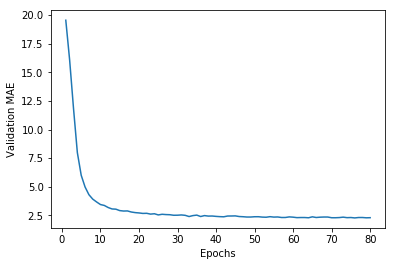

In [18]:
plt.plot(range(1, len(average_mae_history03) + 1), average_mae_history03)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [19]:
smooth_mae_history03 = smooth_curve(average_mae_history03[10:])

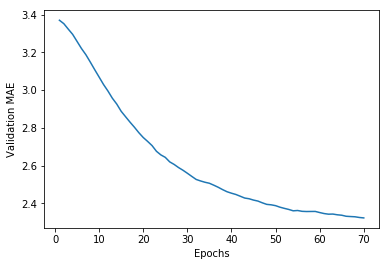

In [20]:
plt.plot(range(1, len(smooth_mae_history03) + 1), smooth_mae_history03)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [21]:
test_mse_score, test_mae_score = model03.evaluate(test_data, test_targets)

 32/102 [========>.....................] - ETA: 0s

In [22]:
print ("Mean absolute error score: " + str(test_mae_score * 1000) + " dls.")

Mean absolute error score: 2732.14549644 dls.


In [23]:
predictions = model03.predict(test_data)

In [24]:
print("Prediction: " + str(predictions[7]))
print("Target: " + str(test_targets[7]))

Prediction: [ 21.19649315]
Target: 22.9


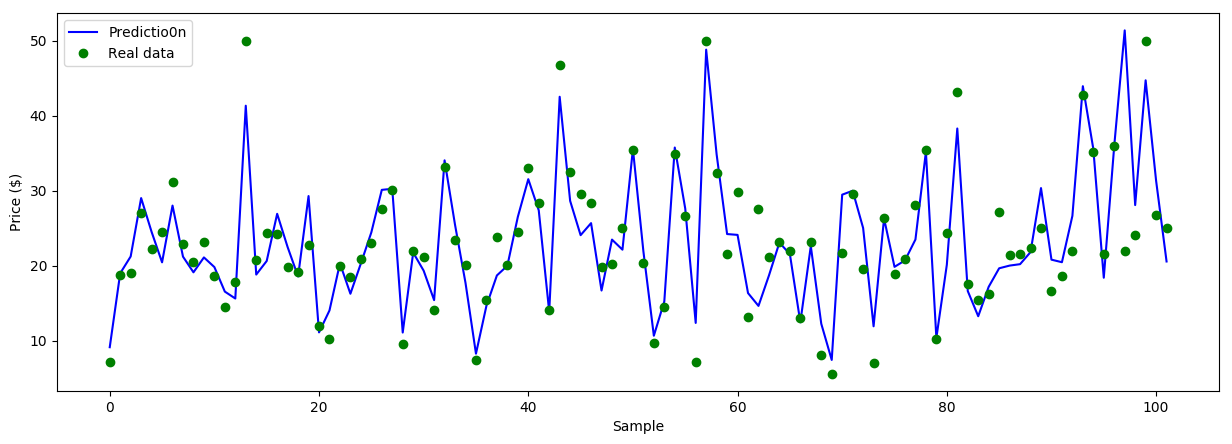

In [25]:
fig = plt.figure(figsize=(15, 5), dpi = 100)
plt.plot(predictions, 'b', label = 'Predictio0n')
plt.plot(test_targets, 'go', label = 'Real data')
plt.xlabel('Sample')
plt.ylabel('Price ($)')
plt.legend()

plt.show()

In [26]:
# The code was removed by DSX for sharing.

# 2nd example

Dataset: House Sales in King County, USA

Source: Kaggle

Link: https://www.kaggle.com/harlfoxem/housesalesprediction

In [27]:
#This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

 #id a notation for a house
 #date Date house was sold
 #price Price is prediction target
 #bedrooms Number of Bedrooms/House
 #bathrooms Number of bathrooms/bedrooms
 #sqft_living square footage of the home
 #sqft_lot square footage of the lot
 #floors Total floors (levels) in house
 #waterfront House which has a view to a waterfront
 #view Has been viewed
 #condition How good the condition is ( Overall )
 #grade overall grade given to the housing unit, based on King County grading system
 #sqft_above square footage of house apart from basement
 #sqft_basement square footage of the basement
 #yr_built Built Year
 #yr_renovated Year when house was renovated
 #zipcode zip
 #lat Latitude coordinate
 #long Longitude coordinate
 #sqft_living15 Living room area in 2015(implies-- some renovations) This might or might not have affected the lotsize area
 #sqft_lot15 lotSize area in 2015(implies-- some renovations)

In [28]:
pd_kaggle.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [29]:
pd_kaggledata = pd_kaggle[['bedrooms', 
           'bathrooms', 
           'sqft_living', 
           'sqft_lot',
           'floors', 
           'waterfront', 
           'view',            
           'condition',
           'grade', 
           'sqft_above', 
           'sqft_basement', 
           'yr_built', 
           'yr_renovated', 
           'zipcode',
           'lat',
           'long',
           'sqft_living15', 
           'sqft_lot15']]

pd_kaggletarget = pd_kaggle[['price']]

In [30]:
pd_kaggledata.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [31]:
pd_kaggletarget.head()

,price
0,221900.0
1,538000.0
2,180000.0
3,604000.0
4,510000.0


In [32]:
pd_kaggletarget /= 1000

In [33]:
pd_kaggletarget.head()

,price
0,221.9
1,538.0
2,180.0
3,604.0
4,510.0


In [34]:
print("Kaggle data shape: " + str(pd_kaggledata.shape))
print("Kaggle target shape: " + str(pd_kaggletarget.shape))

Kaggle data shape: (21613, 18)
Kaggle target shape: (21613, 1)


In [35]:
# The total rows are len(pd_houses) from this total, we take some part as training dataset and the remaining will be our test dataset

print("Data(total rows): " + str(len(pd_kaggledata)))
print("Training set(75%): " + str(len(pd_kaggledata) * 0.75))
print("Test set(25%): " + str(len(pd_kaggledata) * 0.25))

print("\n========================================================================================")

print("\nData(total rows): " + str(len(pd_kaggletarget)))
print("Training set(75%): " + str(len(pd_kaggletarget) * 0.75))
print("Test set(25%): " + str(len(pd_kaggletarget) * 0.25))

Data(total rows): 21613
Training set(75%): 16209.75
Test set(25%): 5403.25


Data(total rows): 21613
Training set(75%): 16209.75
Test set(25%): 5403.25


In [36]:
# ************************************************
# Kaggle data

train_kaggledata = pd_kaggledata[:16209]
test_kaggledata = pd_kaggledata[16210:]

# ************************************************
# Kaggle target

train_kaggletarget = pd_kaggletarget[:16209]
test_kaggletarget = pd_kaggletarget[16210:]

In [37]:
train_kaggledata = train_kaggledata.values
test_kaggledata = test_kaggledata.values

train_kaggletarget = train_kaggletarget.values
test_kaggletarget = test_kaggletarget.values

In [38]:
train_kaggletarget_ = []
test_kaggletarget_ = []

for i in train_kaggletarget:
    train_kaggletarget_.append(int(i))

for j in test_kaggletarget:
    test_kaggletarget_.append(int(j))

train_kaggletarget = np.asarray(train_kaggletarget_)
test_kaggletarget = np.asarray(test_kaggletarget_)

In [39]:
# Get the mean and the std

mean_kaggledata = train_kaggledata.mean(axis = 0)
std_kaggledata = train_kaggledata.std(axis = 0)

# Normalize the train and the dataset

train_kaggledata -= mean_kaggledata
train_kaggledata /= std_kaggledata

test_kaggledata -= mean_kaggledata
test_kaggledata /= std_kaggledata

In [40]:
train_kaggledata

array([[-0.39008177, -1.39975135, -0.96585918, ..., -0.29979538,
        -0.94411808, -0.27849795],
       [-0.39008177,  0.24845648,  0.57125246, ..., -0.74608253,
        -0.42329578, -0.20671489],
       [-1.45596771, -1.39975135, -1.41925182, ..., -0.12703906,
         1.10940983, -0.19144881],
       ..., 
       [ 0.67580417, -0.41082666,  0.68183603, ..., -1.26435148,
        -0.2298475 , -0.25684393],
       [ 0.67580417, -0.08118509,  0.77030289, ..., -1.09879334,
        -1.01852126, -0.41874379],
       [ 0.67580417,  0.57809804,  0.57125246, ..., -1.12758606,
         0.21657161, -0.17307898]])

In [41]:
test_kaggledata

array([[-0.39008177,  0.24845648, -0.39082461, ...,  0.18968085,
         0.30585543, -0.15903996],
       [ 0.67580417,  1.23738117, -0.57881668, ...,  0.49920259,
        -0.06616049, -0.23248317],
       [-0.39008177, -1.39975135, -0.87739232, ...,  0.19687903,
        -1.316134  , -0.18874205],
       ..., 
       [-1.45596771, -1.72939292, -1.14279289, ..., -0.60211893,
        -1.42029846, -0.40997391],
       [-0.39008177,  0.57809804, -0.50140818, ...,  1.05346244,
        -0.83995362, -0.43595873],
       [-1.45596771, -1.72939292, -1.14279289, ..., -0.60211893,
        -1.42029846, -0.43343243]])

In [42]:
model_kaggle = kagglemodel(64, train_kaggledata)

In [43]:
kaggledata_val = train_kaggledata[:1600]
kaggledata_train = train_kaggledata[1600:]

kaggletarget_val = train_kaggletarget[:1600]
kaggletarget_train = train_kaggletarget[1600:]

In [44]:
epochs_kaggle = 80
batch_kaggle = 128

history_kaggle = model_kaggle.fit(kaggledata_train, 
                                 kaggletarget_train, 
                                 epochs = epochs_kaggle, 
                                 batch_size = batch_kaggle, 
                                 validation_data = (kaggledata_val, kaggletarget_val),
                                 verbose = 0)

In [45]:
val_mae_kaggle = history_kaggle.history['val_mean_absolute_error']
mae_kaggle = history_kaggle.history['mean_absolute_error']

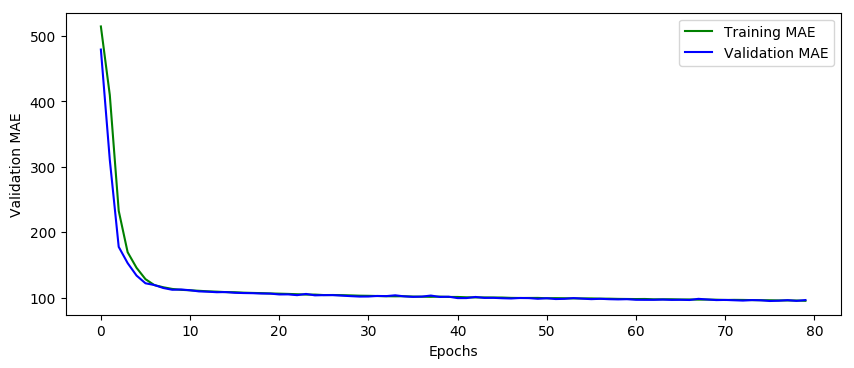

In [46]:
fig = plt.figure(figsize=(10, 4), dpi = 100)
plt.plot(mae_kaggle, 'g', label = 'Training MAE')
plt.plot(val_mae_kaggle, 'b', label = 'Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
plt.show()

In [47]:
smooth_mae_kaggle = smooth_curve(mae_kaggle)

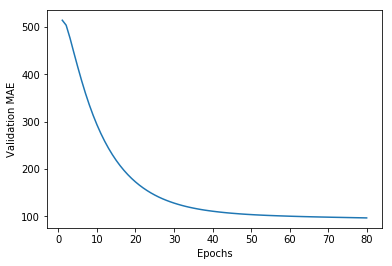

In [48]:
plt.plot(range(1, len(smooth_mae_kaggle) + 1), smooth_mae_kaggle)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [49]:
print("Mean MAE(train): " + str(np.mean(mae_kaggle)))

Mean MAE(train): 114.016138184


In [50]:
test_mse_kaggle, test_mae_kaggle = model_kaggle.evaluate(test_kaggledata,test_kaggletarget)

2784/5403 [==============>...............] - ETA: 0s

In [51]:
print("Test MSE score: " + str(test_mse_kaggle))
print("Test MAE score: " + str(test_mae_kaggle))

Test MSE score: 27712.7281943
Test MAE score: 101.662876606


In [52]:
kaggle_predictions = model_kaggle.predict(test_kaggledata)

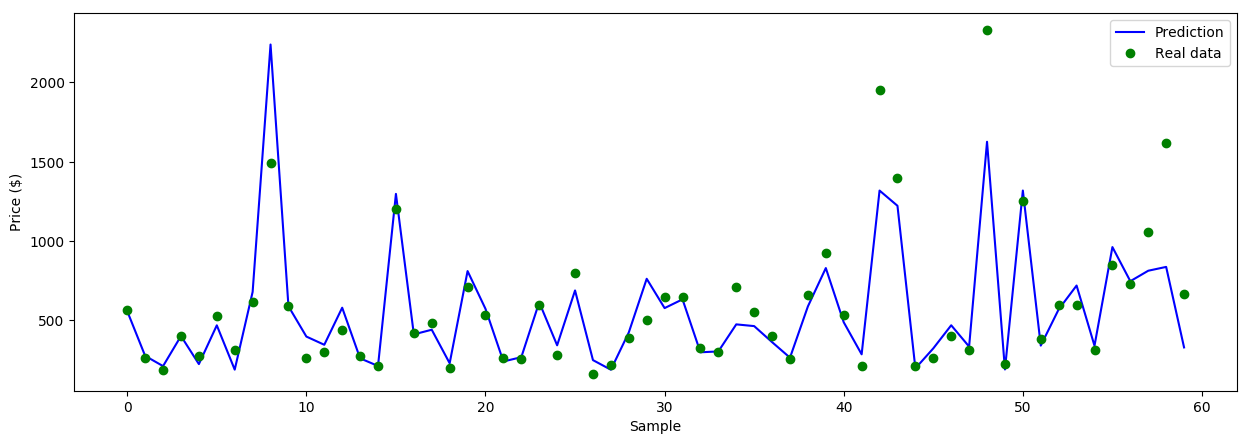

In [53]:
fig = plt.figure(figsize=(15, 5), dpi = 100)
plt.plot(kaggle_predictions[:60], 'b', label = 'Prediction')
plt.plot(test_kaggletarget[:60], 'go', label = 'Real data')
plt.xlabel('Sample')
plt.ylabel('Price ($)')
plt.legend()

plt.show()